## Using lifespan models to make predictions on new data

This notebook shows how to apply the coefficients from pre-estimated normative models to new data. This can be done in two different ways: (i) using a new set of data derived from the same sites used to estimate the model and (ii) on a completely different set of sites. In the latter case, we also need to estimate the site effect, which requires some calibration/adaptation data. As an illustrative example, we use a dataset derived from several [OpenNeuro datasets](https://openneuro.org/) and adapt the learned model to make predictions on these data.

First, if necessary, we install PCNtoolkit (note: this tutorial requires at least version 0.27)

In [1]:
! pip install pcntoolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 835.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   

In [2]:
! git clone https://github.com/predictive-clinical-neuroscience/braincharts.git

Cloning into 'braincharts'...
remote: Enumerating objects: 4558, done.
remote: Counting objects: 100% (305/305), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 4558 (delta 188), reused 202 (delta 97), pack-reused 4253 (from 1)
Receiving objects: 100% (4558/4558), 78.82 MiB | 11.28 MiB/s, done.
Resolving deltas: 100% (688/688), done.


In [9]:
# we need to be in the scripts folder when we import the libraries in the code block below,
# because there is a function called nm_utils that is in the scripts folder that we need to import
import os
wdir = '/content/braincharts'

os.chdir(os.path.join(wdir,'models/')) #this path is setup for running on Google Colab. Change it to match your local path if running locally

Now we import the required libraries

In [10]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import remove_bad_subjects, load_2d

We need to unzip the models.

In [11]:
os.chdir(os.path.join(wdir,'models/'))

In [12]:
# we will use the biggest sample as our training set (approx. N=57000 subjects from 82 sites)
# for more info on the other pretrained models available in this repository,
# please refer to the accompanying paper https://elifesciences.org/articles/72904
! unzip lifespan_DK_46K_59sites.zip

Archive:  lifespan_DK_46K_59sites.zip
   creating: lifespan_DK_46K_59sites/L_inferiortemporal/Models/
  inflating: lifespan_DK_46K_59sites/L_inferiortemporal/Models/meta_data.md  
  inflating: lifespan_DK_46K_59sites/L_inferiortemporal/Models/NM_0_0_estimate.pkl  
   creating: lifespan_DK_46K_59sites/L_temporalpole/Models/
  inflating: lifespan_DK_46K_59sites/L_temporalpole/Models/meta_data.md  
  inflating: lifespan_DK_46K_59sites/L_temporalpole/Models/NM_0_0_estimate.pkl  
   creating: lifespan_DK_46K_59sites/L_postcentral/Models/
  inflating: lifespan_DK_46K_59sites/L_postcentral/Models/meta_data.md  
  inflating: lifespan_DK_46K_59sites/L_postcentral/Models/NM_0_0_estimate.pkl  
   creating: lifespan_DK_46K_59sites/R_isthmuscingulate/Models/
  inflating: lifespan_DK_46K_59sites/R_isthmuscingulate/Models/meta_data.md  
  inflating: lifespan_DK_46K_59sites/R_isthmuscingulate/Models/NM_0_0_estimate.pkl  
   creating: lifespan_DK_46K_59sites/L_superiortemporal/Models/
  inflating: life

Next, we configure some basic variables, like where we want the analysis to be done and which model we want to use.

**Note:** We maintain a list of site ids for each dataset, which describe the site names in the training and test data (`site_ids_tr` and `site_ids_te`), plus also the adaptation data . The training site ids are provided as a text file in the distribution and the test ids are extracted automatically from the pandas dataframe (see below). If you use additional data from the sites (e.g. later waves from ABCD), it may be necessary to adjust the site names to match the names in the training set. See the accompanying paper for more details

In [14]:
# which model do we wish to use?
model_name = 'lifespan_DK_46K_59sites'
site_names = 'site_ids_ct_dk_59sites.txt'

# where the analysis takes place
root_dir = wdir

# where the data files live
data_dir = os.path.join(wdir,'docs')

# where the models live
out_dir = os.path.join(root_dir, 'models', model_name)

# load a set of site ids from this model. This must match the training data
with open(os.path.join(root_dir,'docs', site_names)) as f:
    site_ids_tr = f.read().splitlines()

### Load test data

**Note:** For the purposes of this tutorial, we make predictions for a multi-site transfer dataset, derived from [OpenNeuro](https://openneuro.org/).

In [15]:
from google.colab import files
uploaded = files.upload()


Saving TLE_inputdata_test.csv to TLE_inputdata_test.csv
Saving TLE_inputdata_adaption.csv to TLE_inputdata_adaption.csv


In [17]:
test_data = os.path.join(data_dir, 'TLE_inputdata_test.csv')

df_te = pd.read_csv(test_data)

# extract a list of unique site ids from the test set
site_ids_te =  sorted(set(df_te['site'].to_list()))

### (Optional) Load adaptation data

If the data you wish to make predictions for is not derived from the same scanning sites as those in the trainig set, it is necessary to learn the site effect so that we can account for it in the predictions. In order to do this in an unbiased way, we use a separate dataset, which we refer to as 'adaptation' data. This must contain data for all the same sites as in the test dataset and we assume these are coded in the same way, based on a the 'sitenum' column in the dataframe.

In [18]:
adaptation_data = os.path.join(data_dir, 'TLE_inputdata_adaption.csv')

df_ad = pd.read_csv(adaptation_data)

# extract a list of unique site ids from the test set
site_ids_ad =  sorted(set(df_ad['site'].to_list()))

if not all(elem in site_ids_ad for elem in site_ids_te):
    print('Warning: some of the testing sites are not in the adaptation data')

In [23]:
df_ad = df_ad.rename(columns={'site_id': 'sitenum'})
df_te = df_te.rename(columns={'site_id': 'sitenum'})

### Configure which models to fit

Now, we configure which imaging derived phenotypes (IDPs) we would like to process. This is just a list of column names in the dataframe we have loaded above.

We could load the whole set (i.e. all phenotypes for which we have models for ...

In [24]:
# load the list of idps for left and right hemispheres, plus subcortical regions
with open(os.path.join(data_dir, 'phenotypes_ct_dk_lh.txt')) as f:
    idp_ids_lh = f.read().splitlines()
with open(os.path.join(data_dir, 'phenotypes_ct_dk_rh.txt')) as f:
    idp_ids_rh = f.read().splitlines()
with open(os.path.join(data_dir, 'phenotypes_ct_dk_mean.txt')) as f:
    idp_ids_sc = f.read().splitlines()

# we choose here to process all idps
idp_ids = idp_ids_lh + idp_ids_rh #+ idp_ids_sc

... or alternatively, we could just specify a list

In [ ]:
idp_ids = [ 'Left-Thalamus-Proper', 'Left-Lateral-Ventricle', 'rh_MeanThickness_thickness']

### Configure covariates

Now, we configure some parameters to fit the model. First, we choose which columns of the pandas dataframe contain the covariates (age and sex). The site parameters are configured automatically later on by the `configure_design_matrix()` function, when we loop through the IDPs in the list

The supplied coefficients are derived from a 'warped' Bayesian linear regression model, which uses a nonlinear warping function to model non-Gaussianity (`sinarcsinh`) plus a non-linear basis expansion (a cubic b-spline basis set with 5 knot points, which is the default value in the PCNtoolkit package). Since we are sticking with the default value, we do not need to specify any parameters for this, but we do need to specify the limits. We choose to pad the input by a few years either side of the input range. We will also set a couple of options that control the estimation of the model

For further details about the likelihood warping approach, see the accompanying paper and [Fraza et al 2021](https://www.biorxiv.org/content/10.1101/2021.04.05.438429v1).

In [25]:
# which data columns do we wish to use as covariates?
cols_cov = ['age','sex']

# limits for cubic B-spline basis
xmin = -5
xmax = 110

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

### Make predictions

This will make predictions for each IDP separately. This is done by extracting a column from the dataframe (i.e. specifying the IDP as the response variable) and saving it as a numpy array. Then, we configure the covariates, which is a numpy data array having the number of rows equal to the number of datapoints in the test set. The columns are specified as follows:

- A global intercept (column of ones)
- The covariate columns (here age and sex, coded as 0=female/1=male)
- Dummy coded columns for the sites in the training set (one column per site)
- Columns for the basis expansion (seven columns for the default parameterisation)

Once these are saved as numpy arrays in ascii format (as here) or (alternatively) in pickle format, these are passed as inputs to the `predict()` method in the PCNtoolkit normative modelling framework. These are written in the same format to the location specified by `idp_dir`. At the end of this step, we have a set of predictions and Z-statistics for the test dataset that we can take forward to further analysis.

Note that when we need to make predictions on new data, the procedure is more involved, since we need to prepare, process and store covariates, response variables and site ids for the adaptation data.

In [26]:
for idp_num, idp in enumerate(idp_ids):
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # extract and save the response variables for the test set
    y_te = df_te[idp].to_numpy()

    # save the variables
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt')
    np.savetxt(resp_file_te, y_te)

    # configure and save the design matrix
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    X_te = create_design_matrix(df_te[cols_cov],
                                site_ids = df_te['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline',
                                xmin = xmin,
                                xmax = xmax)
    np.savetxt(cov_file_te, X_te)

    # check whether all sites in the test set are represented in the training set
    if all(elem in site_ids_tr for elem in site_ids_te):
        print('All sites are present in the training data')

        # just make predictions
        yhat_te, s2_te, Z = predict(cov_file_te,
                                    alg='blr',
                                    respfile=resp_file_te,
                                    model_path=os.path.join(idp_dir,'Models'))
    else:
        print('Some sites missing from the training data. Adapting model')

        # save the covariates for the adaptation data
        X_ad = create_design_matrix(df_ad[cols_cov],
                                    site_ids = df_ad['site'],
                                    all_sites = site_ids_tr,
                                    basis = 'bspline',
                                    xmin = xmin,
                                    xmax = xmax)
        cov_file_ad = os.path.join(idp_dir, 'cov_bspline_ad.txt')
        np.savetxt(cov_file_ad, X_ad)

        # save the responses for the adaptation data
        resp_file_ad = os.path.join(idp_dir, 'resp_ad.txt')
        y_ad = df_ad[idp].to_numpy()
        np.savetxt(resp_file_ad, y_ad)

        # save the site ids for the adaptation data
        sitenum_file_ad = os.path.join(idp_dir, 'sitenum_ad.txt')
        site_num_ad = df_ad['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_ad, site_num_ad)

        # save the site ids for the test data
        sitenum_file_te = os.path.join(idp_dir, 'sitenum_te.txt')
        site_num_te = df_te['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_te, site_num_te)

        yhat_te, s2_te, Z = predict(cov_file_te,
                                    alg = 'blr',
                                    respfile = resp_file_te,
                                    model_path = os.path.join(idp_dir,'Models'),
                                    adaptrespfile = resp_file_ad,
                                    adaptcovfile = cov_file_ad,
                                    adaptvargroupfile = sitenum_file_ad,
                                    testvargroupfile = sitenum_file_te)

Running IDP 0 L_bankssts :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 L_caudalanteriorcingulate :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 L_caudalmiddlefrontal :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 3 L_cuneus :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 4 L_entorhinal :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the m

### Preparing dummy data for plotting

Now, we plot the centiles of variation estimated by the normative model.

We do this by making use of a set of dummy covariates that span the whole range of the input space (for age) for a fixed value of the other covariates (e.g. sex) so that we can make predictions for these dummy data points, then plot them. We configure these dummy predictions using the same procedure as we used for the real data. We can use the same dummy data for all the IDPs we wish to plot

In [27]:
# which sex do we want to plot?
sex = 1 # 1 = male 0 = female
if sex == 1:
    clr = 'blue';
else:
    clr = 'red'

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), 2))
X0_dummy[:,0] = xx
X0_dummy[:,1] = sex

# create the design matrix
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, site_ids=None, all_sites=site_ids_tr)

# save the dummy covariates
cov_file_dummy = os.path.join(out_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)

configuring dummy data ...


### Plotting the normative models

Now we loop through the IDPs, plotting each one separately. The outputs of this step are a set of quantitative regression metrics for each IDP and a set of centile curves which we plot the test data against.

This part of the code is relatively complex because we need to keep track of many quantities for the plotting. We also need to remember whether the data need to be warped or not. By default in PCNtoolkit, predictions in the form of `yhat, s2` are always in the warped (Gaussian) space. If we want predictions in the input (non-Gaussian) space, then we need to warp them with the inverse of the estimated warping function. This can be done using the function `nm.blr.warp.warp_predictions()`.

**Note:** it is necessary to update the intercept for each of the sites. For purposes of visualisation, here we do this by adjusting the median of the data to match the dummy predictions, but note that all the quantitative metrics are estimated using the predictions that are adjusted properly using a learned offset (or adjusted using a hold-out adaptation set, as above). Note also that for the calibration data we require at least two data points of the same sex in each site to be able to estimate the variance. Of course, in a real example, you would want many more than just two since we need to get a reliable estimate of the variance for each site.

Running IDP 0 L_bankssts :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18562017]), 'Rho': array([0.32428834]), 'pRho': array([0.00110696]), 'SMSE': array([0.90281476]), 'EXPV': array([0.09933756])}


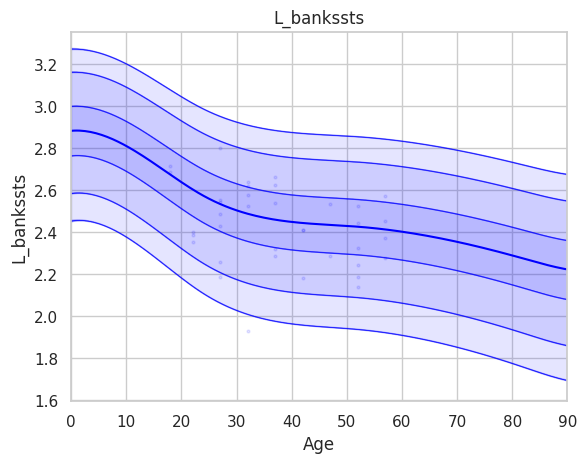

Running IDP 1 L_caudalanteriorcingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21833603]), 'Rho': array([0.36413175]), 'pRho': array([0.00021547]), 'SMSE': array([0.89998945]), 'EXPV': array([0.11671983])}


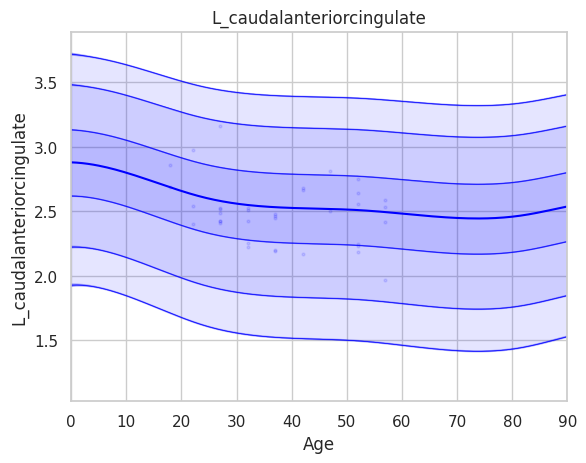

Running IDP 2 L_caudalmiddlefrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16659731]), 'Rho': array([0.42190321]), 'pRho': array([1.28313519e-05]), 'SMSE': array([0.98989368]), 'EXPV': array([0.15854454])}


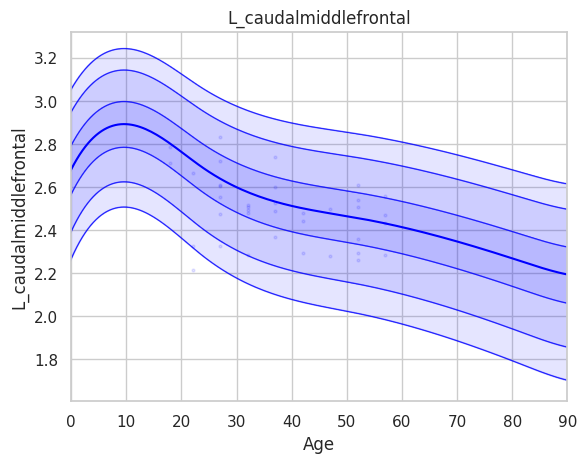

Running IDP 3 L_cuneus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14138147]), 'Rho': array([0.26262854]), 'pRho': array([0.00912409]), 'SMSE': array([0.9469014]), 'EXPV': array([0.05551204])}


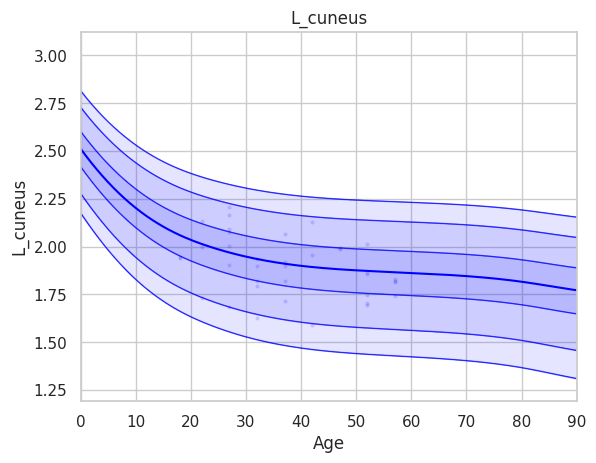

Running IDP 4 L_entorhinal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.35149244]), 'Rho': array([0.2373894]), 'pRho': array([0.01895915]), 'SMSE': array([1.18510002]), 'EXPV': array([-0.18096125])}


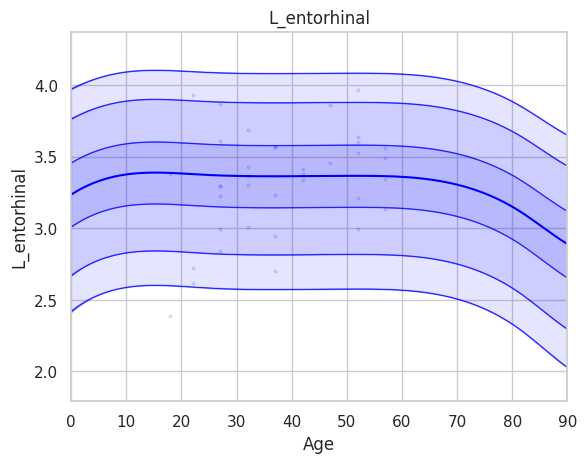

Running IDP 5 L_fusiform :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13769135]), 'Rho': array([0.17035508]), 'pRho': array([0.09533252]), 'SMSE': array([1.07386078]), 'EXPV': array([-0.03924323])}


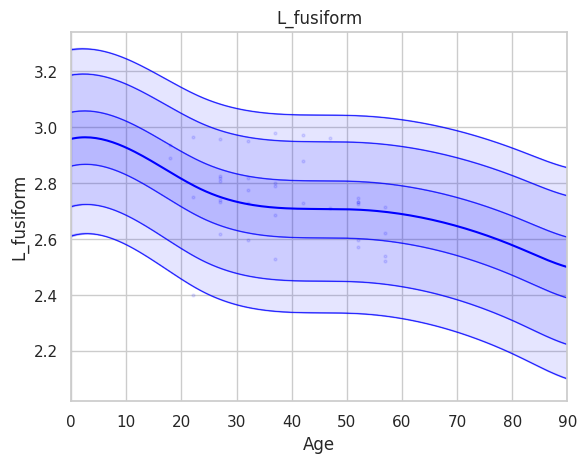

Running IDP 6 L_inferiorparietal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15707716]), 'Rho': array([0.29354011]), 'pRho': array([0.00336544]), 'SMSE': array([1.0830063]), 'EXPV': array([0.06637698])}


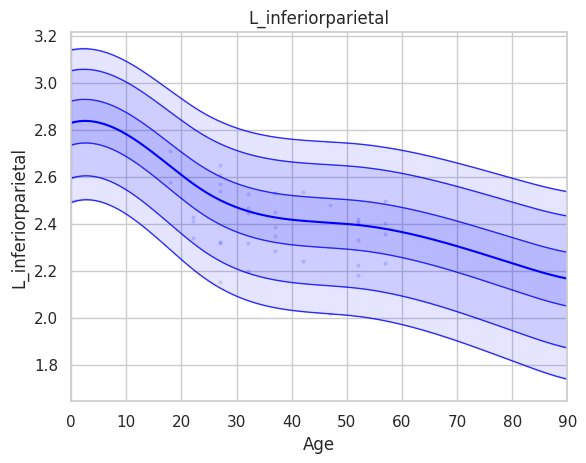

Running IDP 7 L_inferiortemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16488326]), 'Rho': array([0.03474371]), 'pRho': array([0.73612566]), 'SMSE': array([1.25229192]), 'EXPV': array([-0.07970186])}


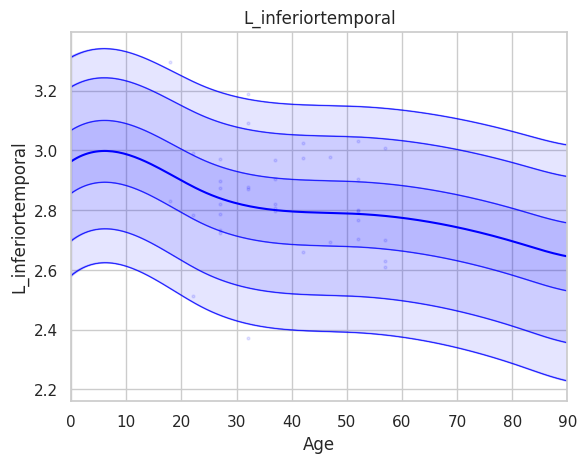

Running IDP 8 L_isthmuscingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.191432]), 'Rho': array([0.40625311]), 'pRho': array([2.91740393e-05]), 'SMSE': array([0.83528802]), 'EXPV': array([0.16486832])}


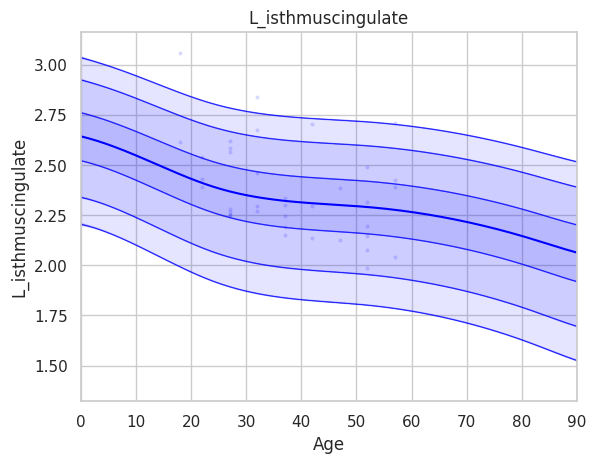

Running IDP 9 L_lateraloccipital :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11278316]), 'Rho': array([0.34720563]), 'pRho': array([0.0004443]), 'SMSE': array([1.01950008]), 'EXPV': array([0.10374535])}


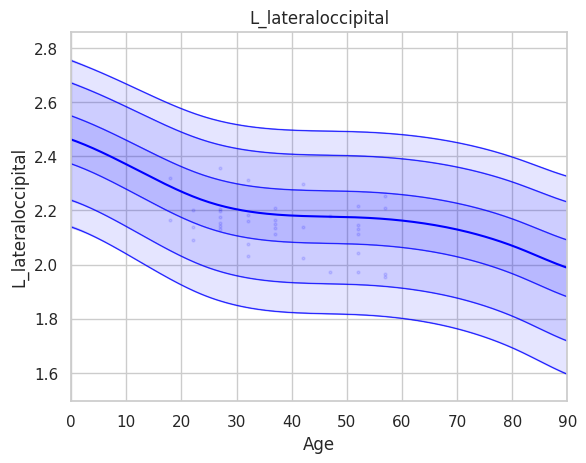

Running IDP 10 L_lateralorbitofrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14241731]), 'Rho': array([0.63036962]), 'pRho': array([6.28093943e-13]), 'SMSE': array([0.68812664]), 'EXPV': array([0.3118751])}


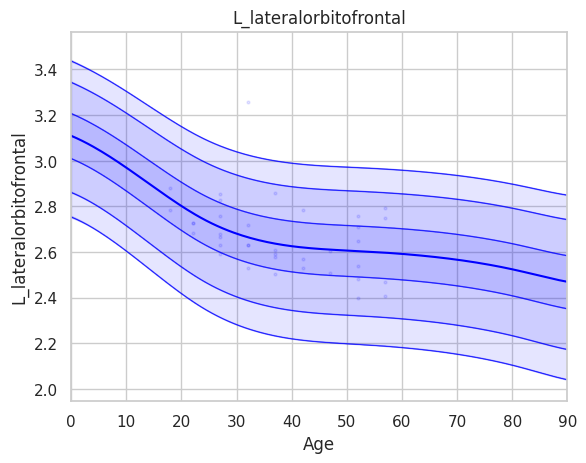

Running IDP 11 L_lingual :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14082732]), 'Rho': array([0.42453948]), 'pRho': array([1.11233524e-05]), 'SMSE': array([0.82685512]), 'EXPV': array([0.17487696])}


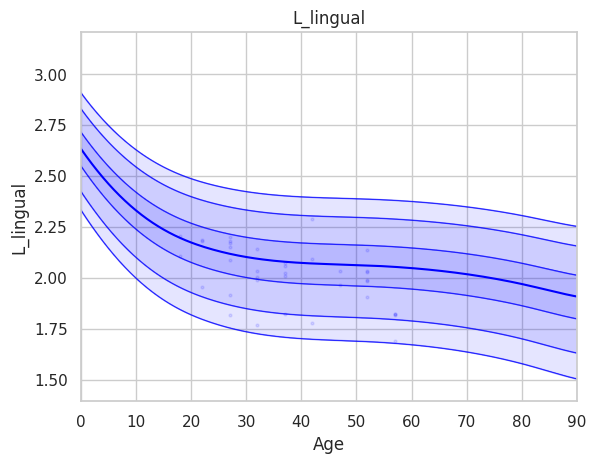

Running IDP 12 L_medialorbitofrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18225206]), 'Rho': array([0.43746815]), 'pRho': array([5.41455347e-06]), 'SMSE': array([0.8564873]), 'EXPV': array([0.15449167])}


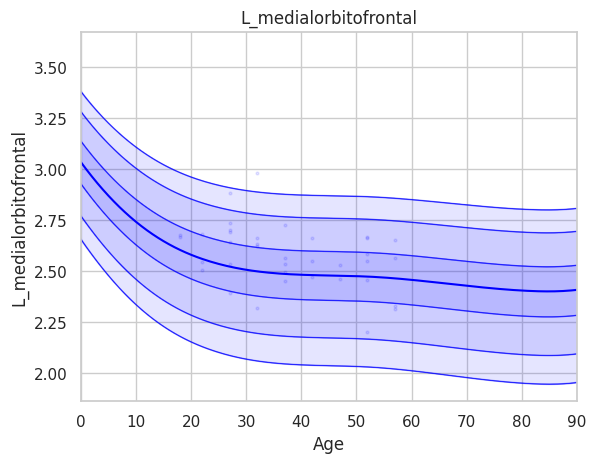

Running IDP 13 L_middletemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12565678]), 'Rho': array([0.52831418]), 'pRho': array([1.20534524e-08]), 'SMSE': array([0.73111635]), 'EXPV': array([0.27080849])}


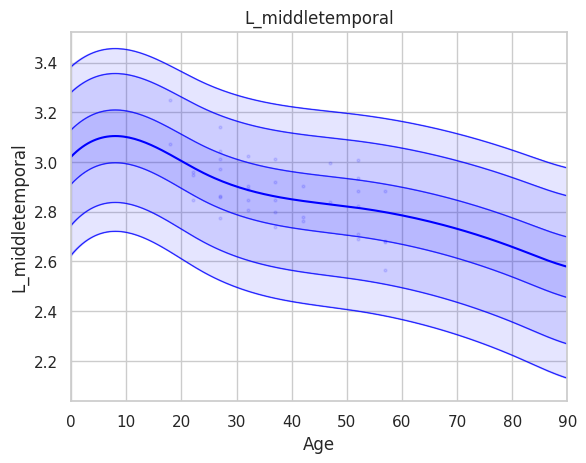

Running IDP 14 L_parahippocampal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.29715963]), 'Rho': array([0.06744376]), 'pRho': array([0.5125414]), 'SMSE': array([1.03904338]), 'EXPV': array([-0.03322416])}


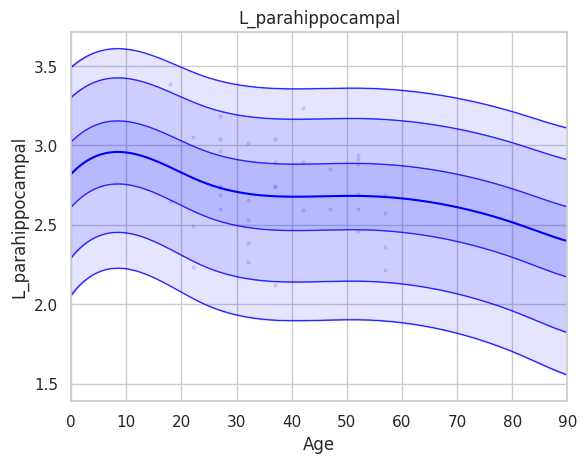

Running IDP 15 L_paracentral :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18632947]), 'Rho': array([0.32935954]), 'pRho': array([0.0009103]), 'SMSE': array([0.98128053]), 'EXPV': array([0.10550328])}


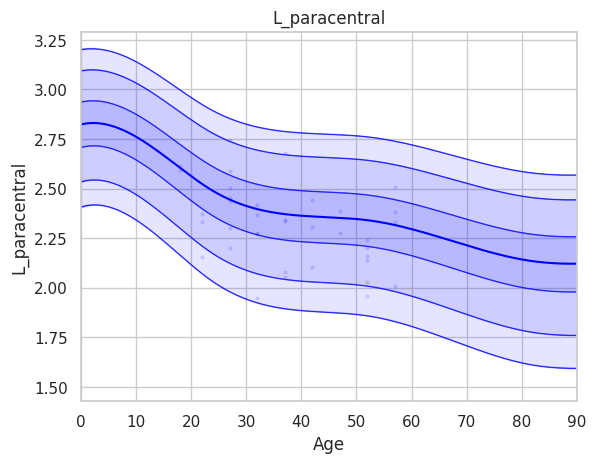

Running IDP 16 L_parsopercularis :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15283262]), 'Rho': array([0.49996685]), 'pRho': array([1.00790927e-07]), 'SMSE': array([0.77137744]), 'EXPV': array([0.24743267])}


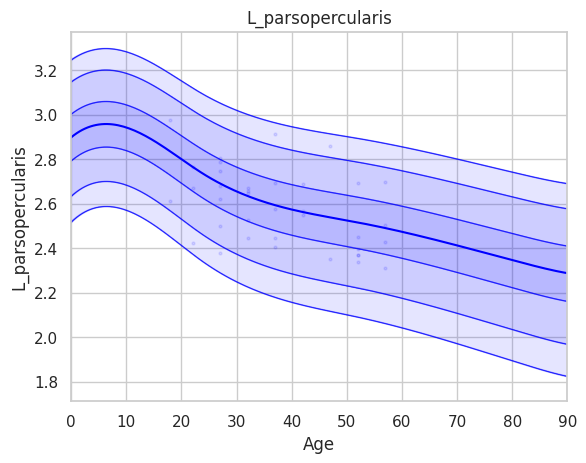

Running IDP 17 L_parsorbitalis :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20153649]), 'Rho': array([0.37324859]), 'pRho': array([0.00014328]), 'SMSE': array([0.8707094]), 'EXPV': array([0.13429847])}


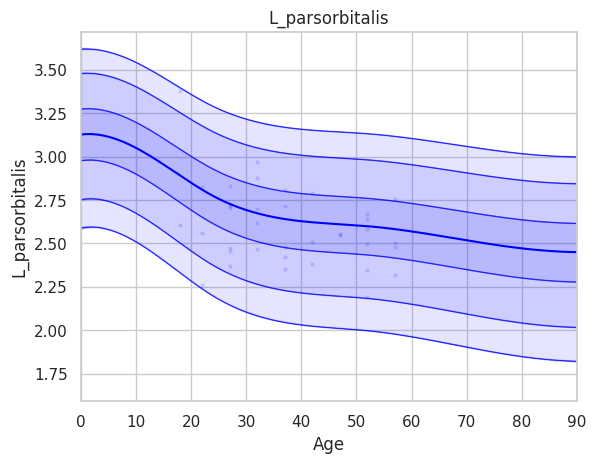

Running IDP 18 L_parstriangularis :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14859812]), 'Rho': array([0.59053193]), 'pRho': array([4.76397735e-11]), 'SMSE': array([0.6553837]), 'EXPV': array([0.34576848])}


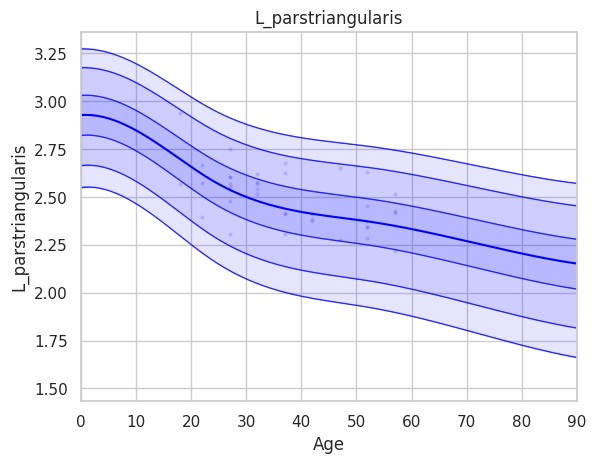

Running IDP 19 L_pericalcarine :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1659751]), 'Rho': array([0.43856637]), 'pRho': array([5.08561801e-06]), 'SMSE': array([0.92679291]), 'EXPV': array([0.13494949])}


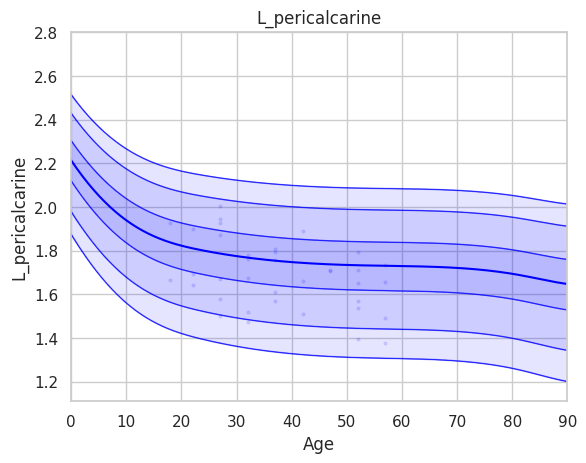

Running IDP 20 L_postcentral :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1188602]), 'Rho': array([0.44950788]), 'pRho': array([2.68750678e-06]), 'SMSE': array([0.8168829]), 'EXPV': array([0.20073508])}


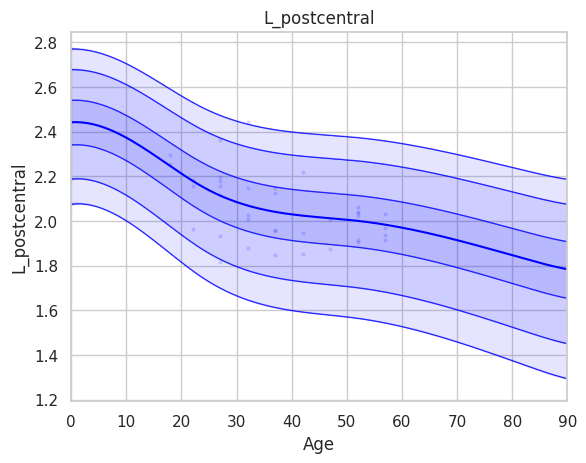

Running IDP 21 L_posteriorcingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15389741]), 'Rho': array([0.38054666]), 'pRho': array([0.00010236]), 'SMSE': array([0.86261456]), 'EXPV': array([0.14416428])}


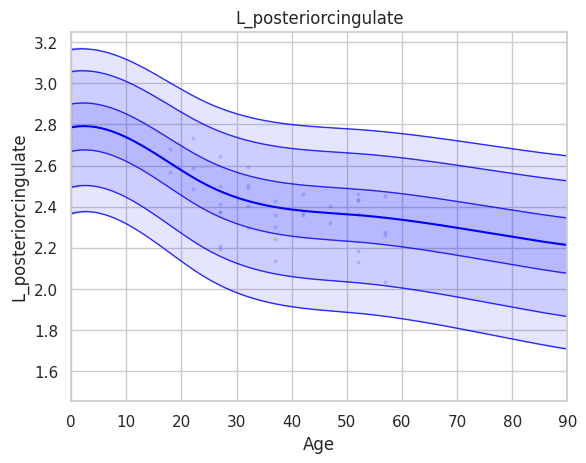

Running IDP 22 L_precentral :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17248977]), 'Rho': array([0.30058838]), 'pRho': array([0.00263689]), 'SMSE': array([1.00506927]), 'EXPV': array([0.04159131])}


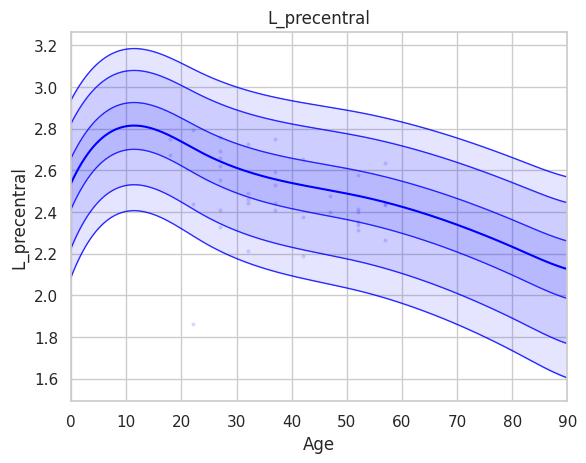

Running IDP 23 L_precuneus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12430323]), 'Rho': array([0.47128961]), 'pRho': array([6.99954589e-07]), 'SMSE': array([0.81452328]), 'EXPV': array([0.21831191])}


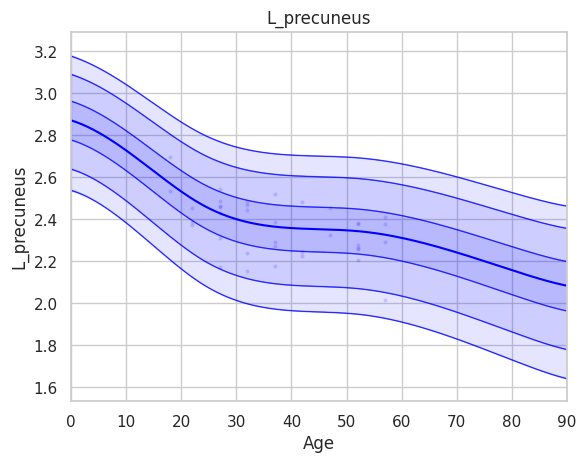

Running IDP 24 L_rostralanteriorcingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21214305]), 'Rho': array([0.28841276]), 'pRho': array([0.00400314]), 'SMSE': array([0.95966951]), 'EXPV': array([0.04336078])}


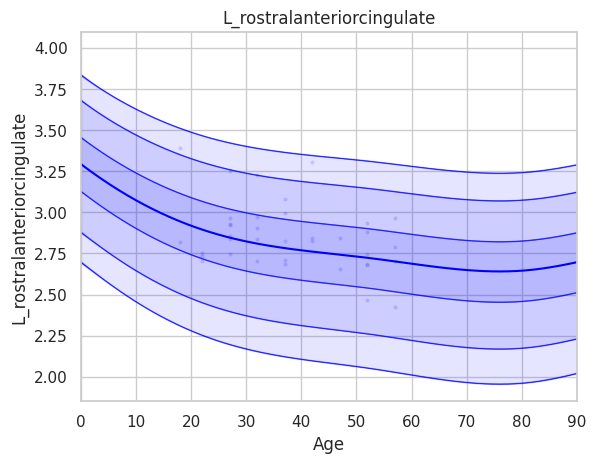

Running IDP 25 L_rostralmiddlefrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12941951]), 'Rho': array([0.53564248]), 'pRho': array([6.70847128e-09]), 'SMSE': array([0.86504874]), 'EXPV': array([0.19480729])}


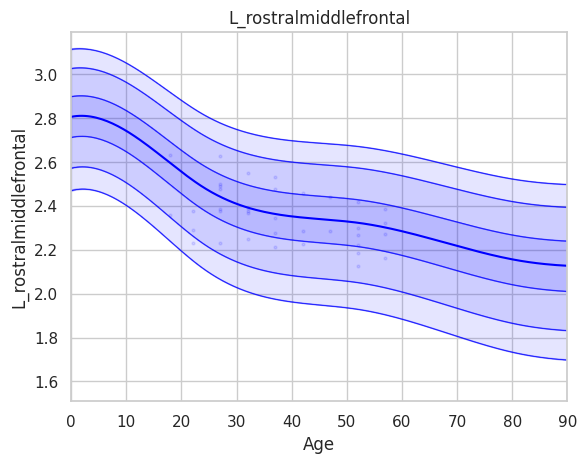

Running IDP 26 L_superiorfrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1616836]), 'Rho': array([0.44754611]), 'pRho': array([3.01856902e-06]), 'SMSE': array([0.9147671]), 'EXPV': array([0.16637056])}


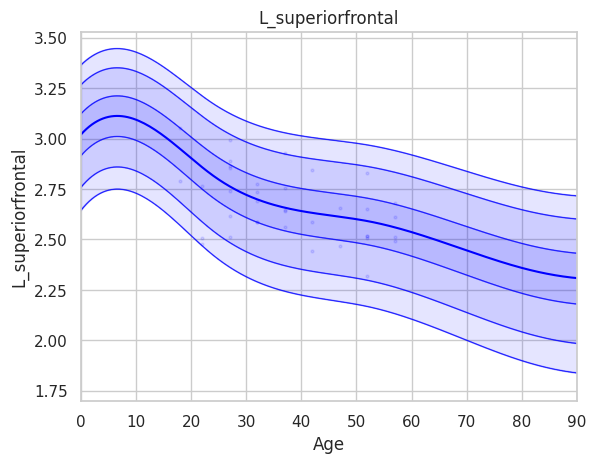

Running IDP 27 L_superiorparietal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13331171]), 'Rho': array([0.20598227]), 'pRho': array([0.04275883]), 'SMSE': array([1.13737503]), 'EXPV': array([-0.03743889])}


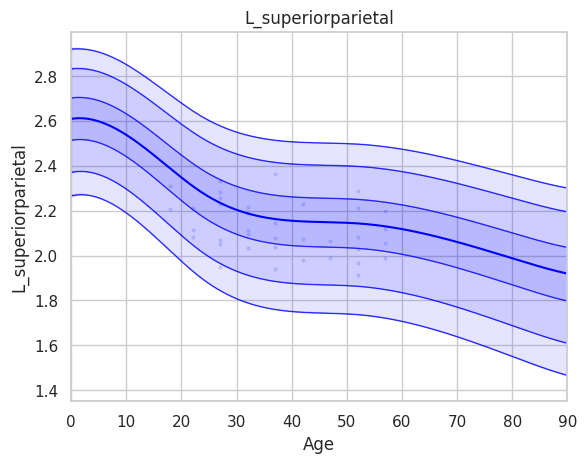

Running IDP 28 L_superiortemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15904501]), 'Rho': array([0.352118]), 'pRho': array([0.00036174]), 'SMSE': array([0.89673403]), 'EXPV': array([0.11340044])}


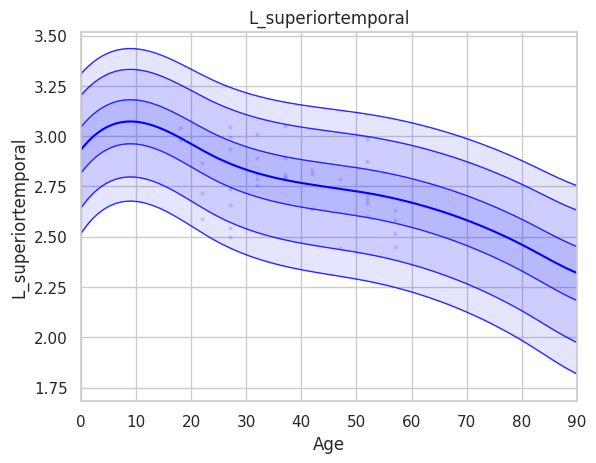

Running IDP 29 L_supramarginal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15286305]), 'Rho': array([0.4473155]), 'pRho': array([3.05991095e-06]), 'SMSE': array([0.95709124]), 'EXPV': array([0.19095955])}


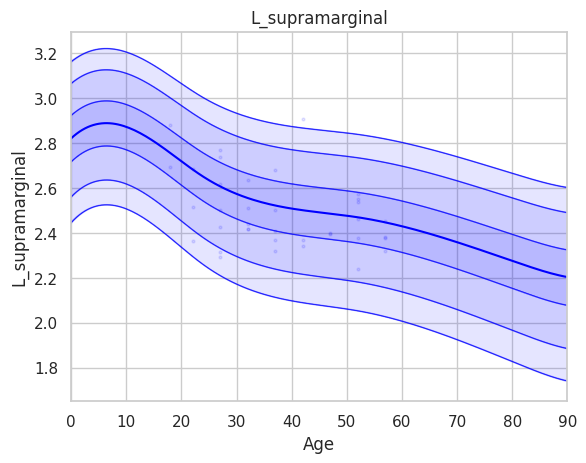

Running IDP 30 L_frontalpole :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.27784645]), 'Rho': array([0.09603935]), 'pRho': array([0.35029627]), 'SMSE': array([1.02346426]), 'EXPV': array([-0.01958316])}


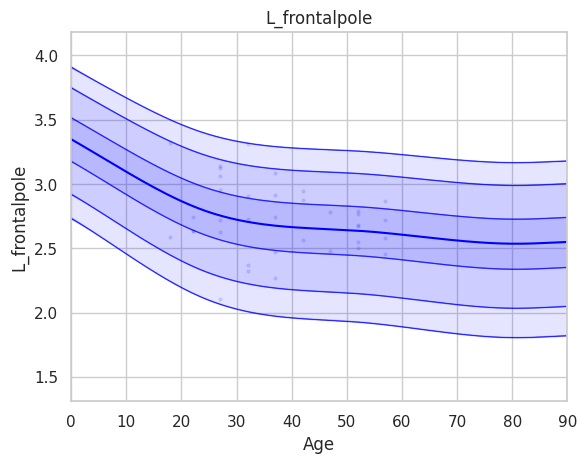

Running IDP 31 L_temporalpole :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.30710443]), 'Rho': array([0.09040198]), 'pRho': array([0.37946681]), 'SMSE': array([1.01998597]), 'EXPV': array([-0.01870231])}


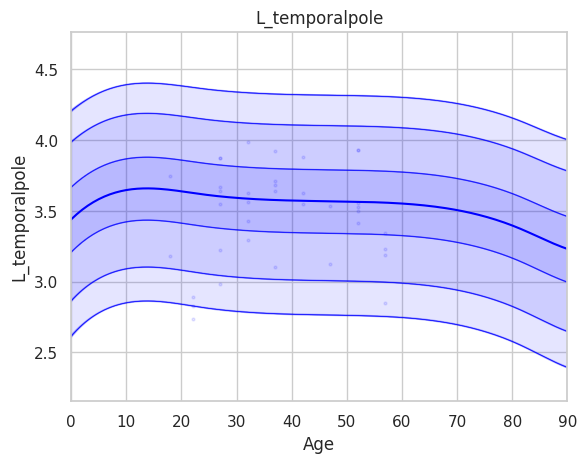

Running IDP 32 L_transversetemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.24643043]), 'Rho': array([0.21309971]), 'pRho': array([0.03588451]), 'SMSE': array([0.99404967]), 'EXPV': array([0.00990961])}


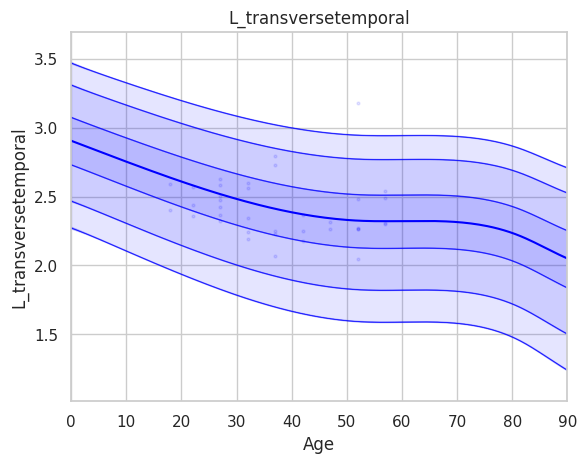

Running IDP 33 L_insula :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15824233]), 'Rho': array([0.40963586]), 'pRho': array([2.45209462e-05]), 'SMSE': array([0.86363301]), 'EXPV': array([0.15132759])}


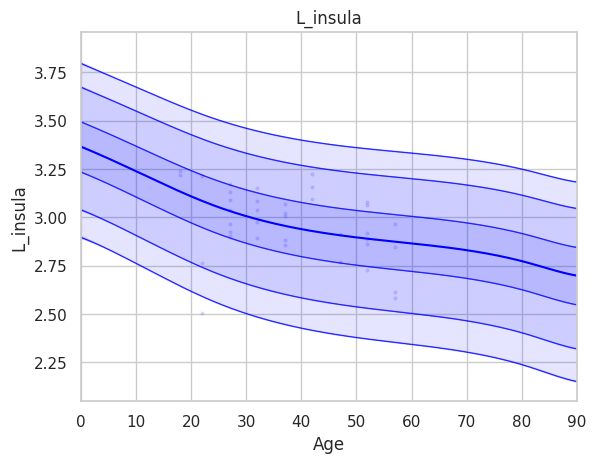

Running IDP 34 R_bankssts :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20078039]), 'Rho': array([0.45022567]), 'pRho': array([2.57515161e-06]), 'SMSE': array([0.82324483]), 'EXPV': array([0.18858141])}


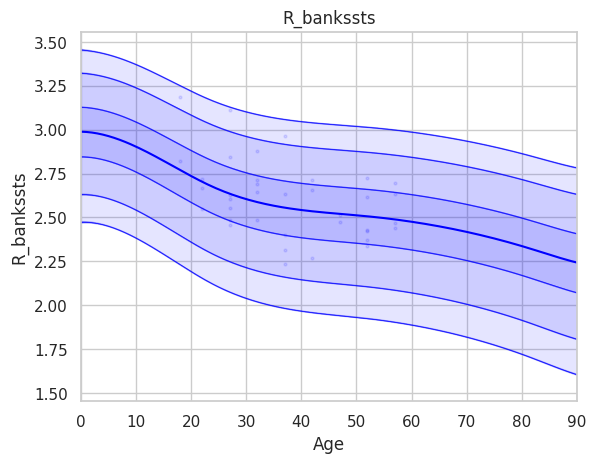

Running IDP 35 R_caudalanteriorcingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20467228]), 'Rho': array([0.24564313]), 'pRho': array([0.01504419]), 'SMSE': array([0.95384472]), 'EXPV': array([0.05994287])}


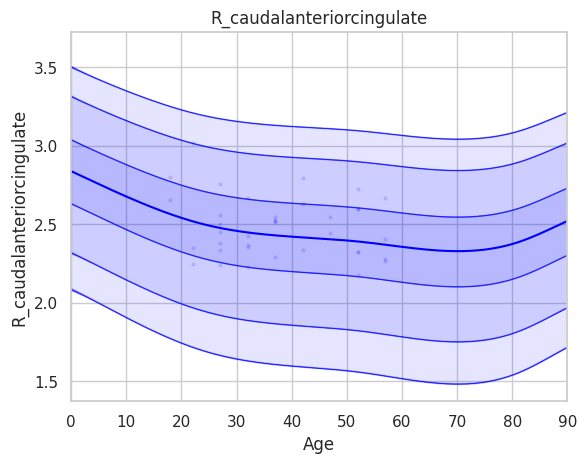

Running IDP 36 R_caudalmiddlefrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14868399]), 'Rho': array([0.4137544]), 'pRho': array([1.97902251e-05]), 'SMSE': array([0.88846745]), 'EXPV': array([0.13765073])}


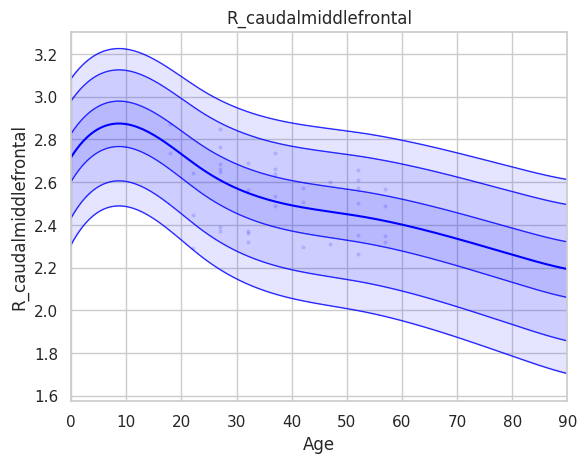

Running IDP 37 R_cuneus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13317836]), 'Rho': array([0.26267377]), 'pRho': array([0.00911155]), 'SMSE': array([0.94787282]), 'EXPV': array([0.05735273])}


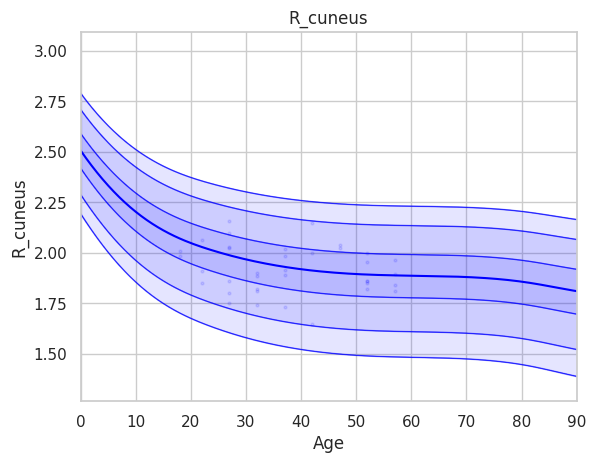

Running IDP 38 R_entorhinal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.32044482]), 'Rho': array([0.34742303]), 'pRho': array([0.00044031]), 'SMSE': array([1.01957126]), 'EXPV': array([0.00759955])}


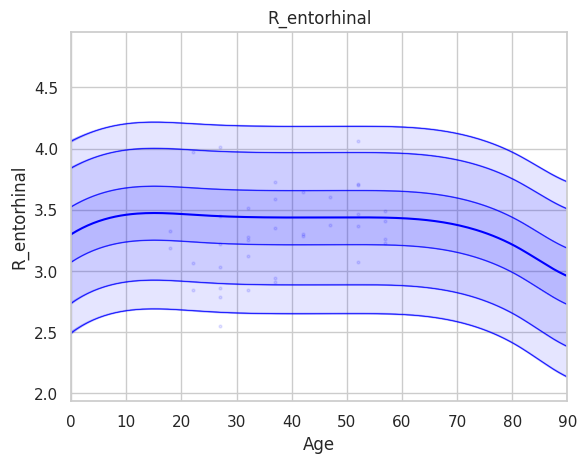

Running IDP 39 R_fusiform :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15039931]), 'Rho': array([0.27412269]), 'pRho': array([0.00638239]), 'SMSE': array([1.07541198]), 'EXPV': array([-0.01164918])}


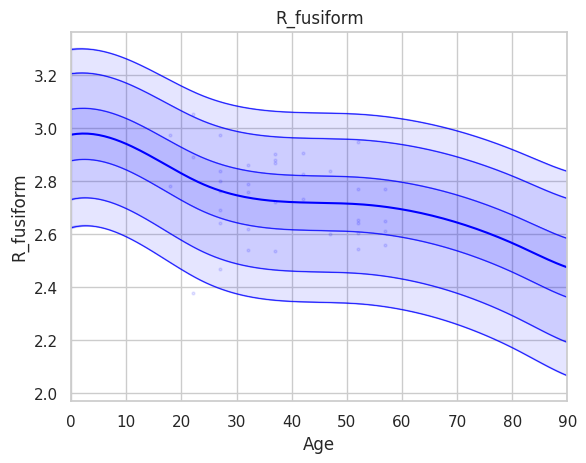

Running IDP 40 R_inferiorparietal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14061299]), 'Rho': array([0.22337757]), 'pRho': array([0.02760421]), 'SMSE': array([1.10553288]), 'EXPV': array([-0.05172637])}


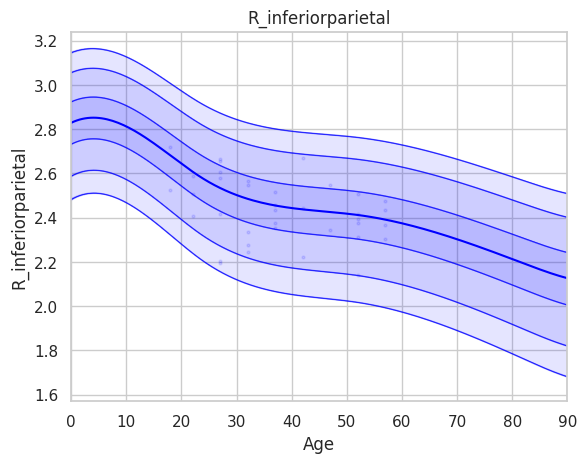

Running IDP 41 R_inferiortemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17130606]), 'Rho': array([0.21846213]), 'pRho': array([0.03133728]), 'SMSE': array([1.02813895]), 'EXPV': array([0.04551354])}


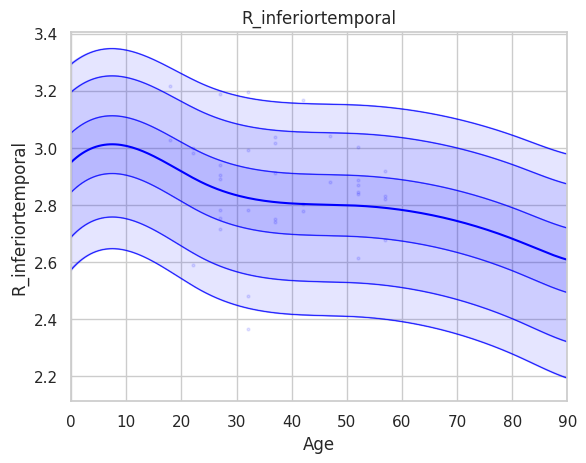

Running IDP 42 R_isthmuscingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.2080544]), 'Rho': array([0.40475371]), 'pRho': array([3.14890194e-05]), 'SMSE': array([0.84630038]), 'EXPV': array([0.16228269])}


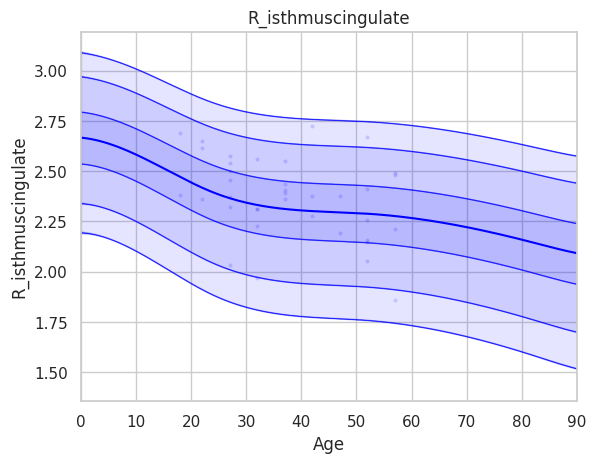

Running IDP 43 R_lateraloccipital :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10952413]), 'Rho': array([0.3022173]), 'pRho': array([0.00249007]), 'SMSE': array([0.94416443]), 'EXPV': array([0.08037118])}


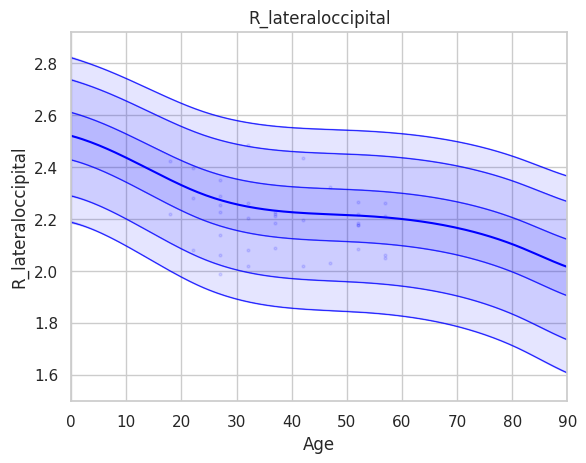

Running IDP 44 R_lateralorbitofrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14124865]), 'Rho': array([0.6456573]), 'pRho': array([9.74998434e-14]), 'SMSE': array([0.62614042]), 'EXPV': array([0.40209988])}


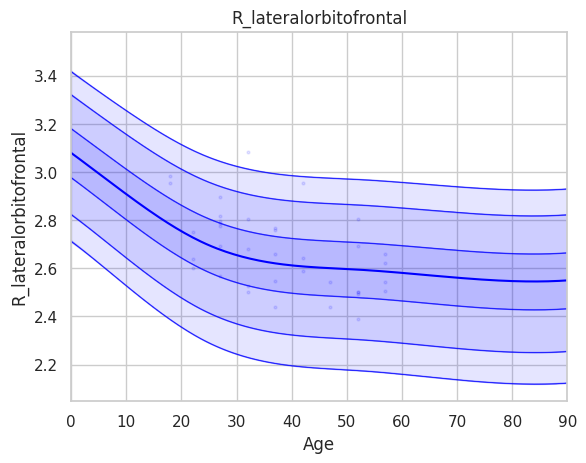

Running IDP 45 R_lingual :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14905603]), 'Rho': array([0.35404525]), 'pRho': array([0.00033338]), 'SMSE': array([0.87565497]), 'EXPV': array([0.12435563])}


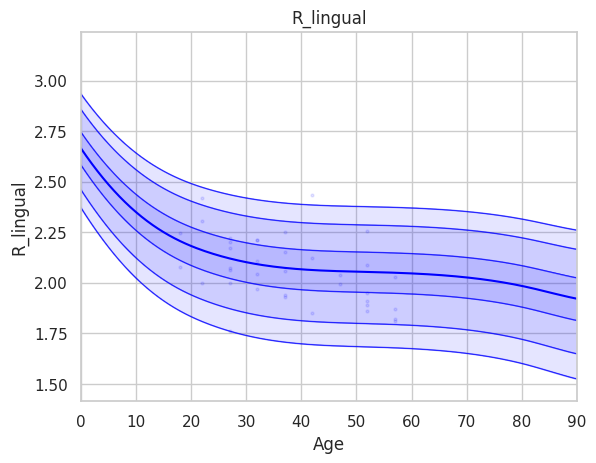

Running IDP 46 R_medialorbitofrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16739296]), 'Rho': array([0.5595327]), 'pRho': array([8.84624491e-10]), 'SMSE': array([0.69767789]), 'EXPV': array([0.30591254])}


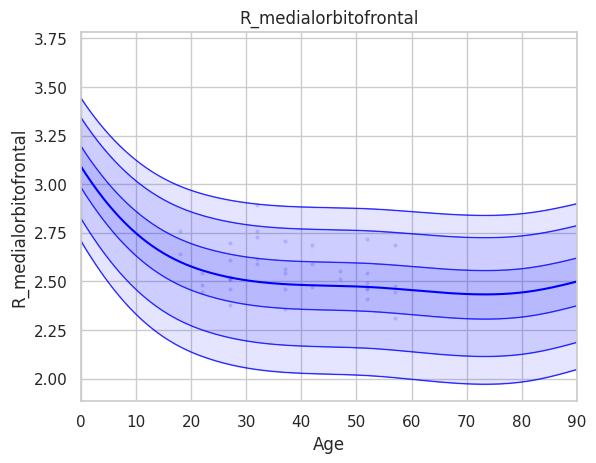

Running IDP 47 R_middletemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13555421]), 'Rho': array([0.50741113]), 'pRho': array([5.89344597e-08]), 'SMSE': array([0.7770505]), 'EXPV': array([0.24632168])}


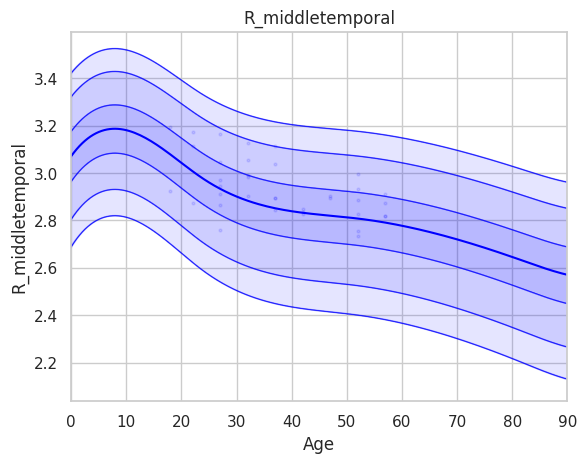

Running IDP 48 R_parahippocampal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.24776059]), 'Rho': array([0.10055059]), 'pRho': array([0.32798546]), 'SMSE': array([1.11222016]), 'EXPV': array([-0.09255102])}


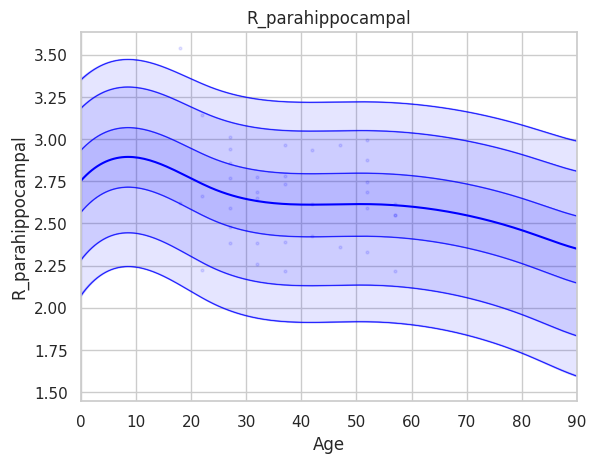

Running IDP 49 R_paracentral :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1814199]), 'Rho': array([0.39834257]), 'pRho': array([4.34520547e-05]), 'SMSE': array([0.92806014]), 'EXPV': array([0.15493641])}


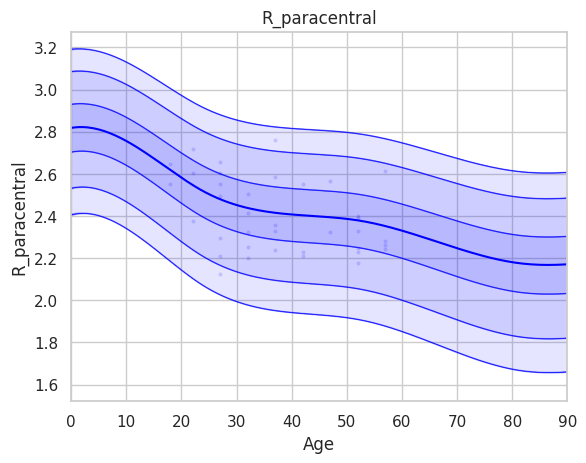

Running IDP 50 R_parsopercularis :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13341188]), 'Rho': array([0.53860623]), 'pRho': array([5.26885063e-09]), 'SMSE': array([0.75273051]), 'EXPV': array([0.27615326])}


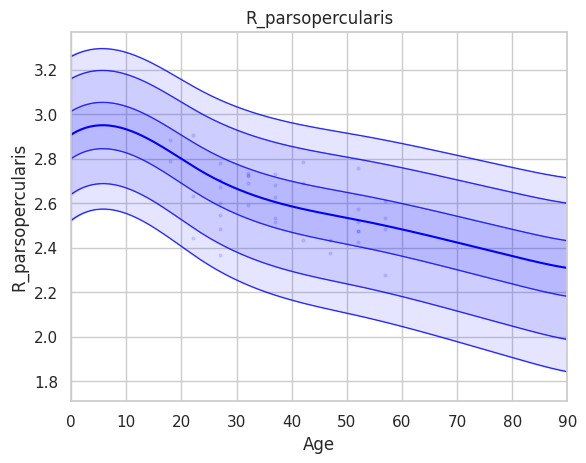

Running IDP 51 R_parsorbitalis :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19387752]), 'Rho': array([0.40592198]), 'pRho': array([2.96712081e-05]), 'SMSE': array([0.84497445]), 'EXPV': array([0.15697065])}


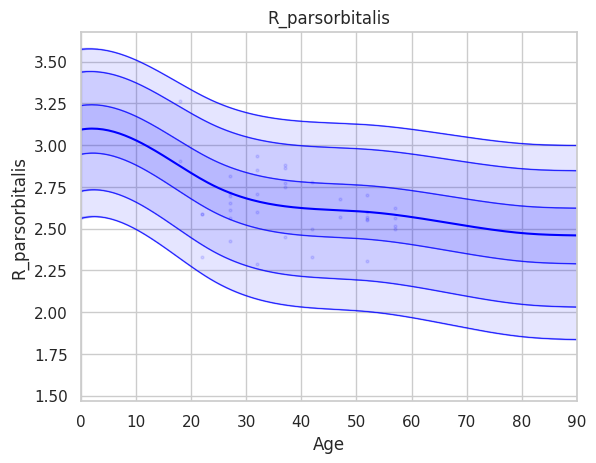

Running IDP 52 R_parstriangularis :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15047456]), 'Rho': array([0.55078006]), 'pRho': array([1.8982945e-09]), 'SMSE': array([0.75395932]), 'EXPV': array([0.30066432])}


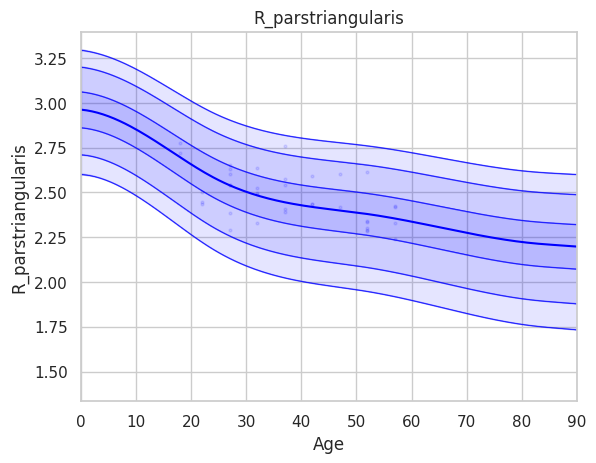

Running IDP 53 R_pericalcarine :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15119288]), 'Rho': array([0.11171611]), 'pRho': array([0.27674175]), 'SMSE': array([1.07185656]), 'EXPV': array([-0.03742793])}


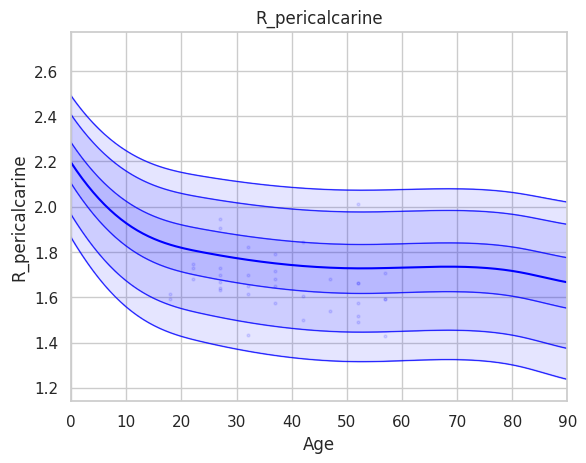

Running IDP 54 R_postcentral :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11076433]), 'Rho': array([0.36399591]), 'pRho': array([0.00021677]), 'SMSE': array([0.90736591]), 'EXPV': array([0.09275233])}


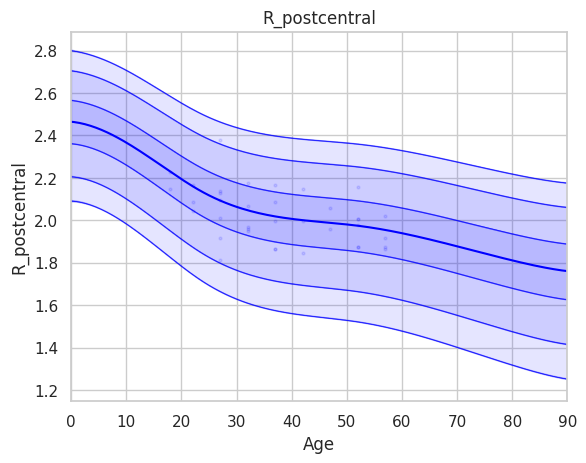

Running IDP 55 R_posteriorcingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15376672]), 'Rho': array([0.38929954]), 'pRho': array([6.76102322e-05]), 'SMSE': array([0.92948807]), 'EXPV': array([0.14951705])}


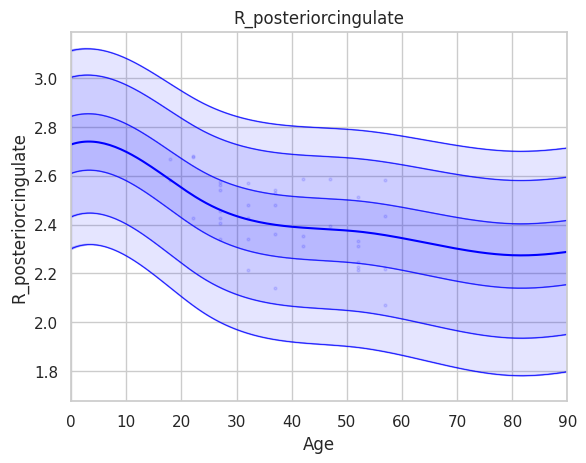

Running IDP 56 R_precentral :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16939767]), 'Rho': array([0.38156566]), 'pRho': array([9.76024465e-05]), 'SMSE': array([0.90249529]), 'EXPV': array([0.14014693])}


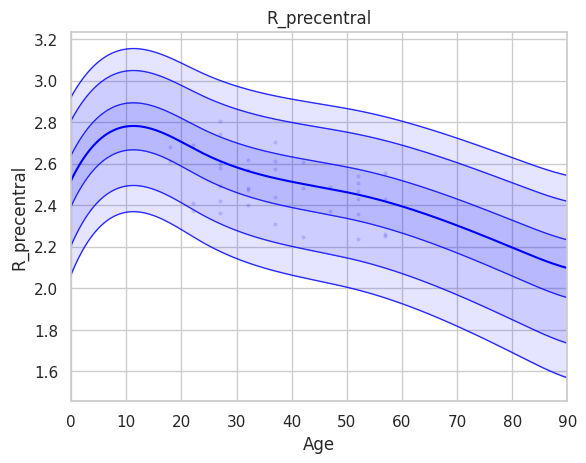

Running IDP 57 R_precuneus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13764642]), 'Rho': array([0.44482409]), 'pRho': array([3.54184418e-06]), 'SMSE': array([0.81003865]), 'EXPV': array([0.19731015])}


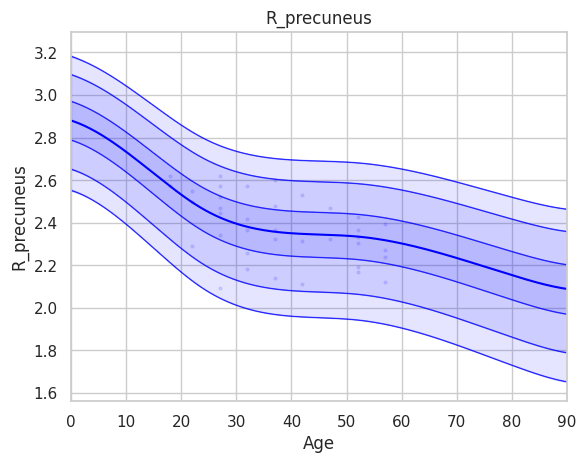

Running IDP 58 R_rostralanteriorcingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1882005]), 'Rho': array([0.33419269]), 'pRho': array([0.00075296]), 'SMSE': array([0.88940287]), 'EXPV': array([0.11133365])}


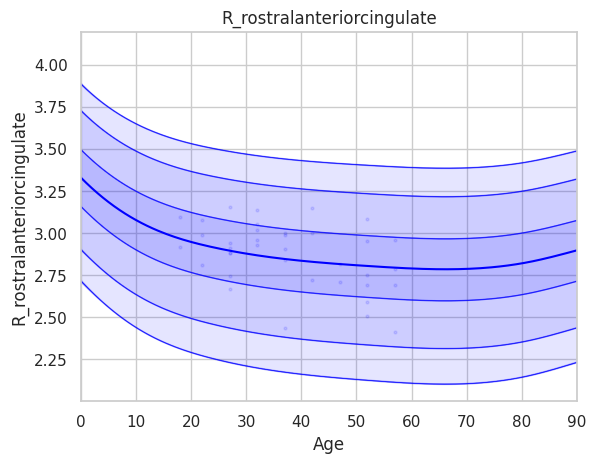

Running IDP 59 R_rostralmiddlefrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11122943]), 'Rho': array([0.6734248]), 'pRho': array([2.35701493e-15]), 'SMSE': array([0.60332911]), 'EXPV': array([0.39667098])}


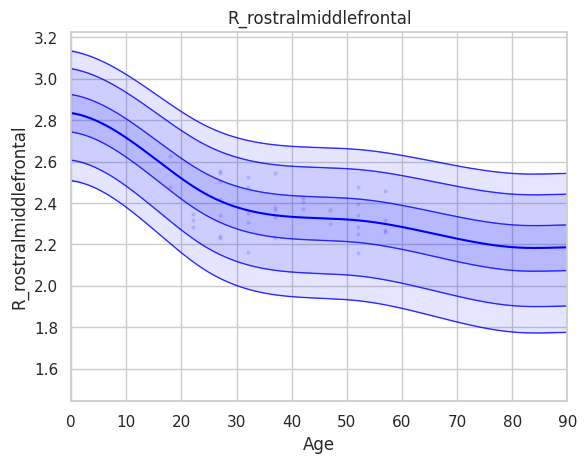

Running IDP 60 R_superiorfrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15641287]), 'Rho': array([0.43449762]), 'pRho': array([6.4071168e-06]), 'SMSE': array([0.9672624]), 'EXPV': array([0.11179086])}


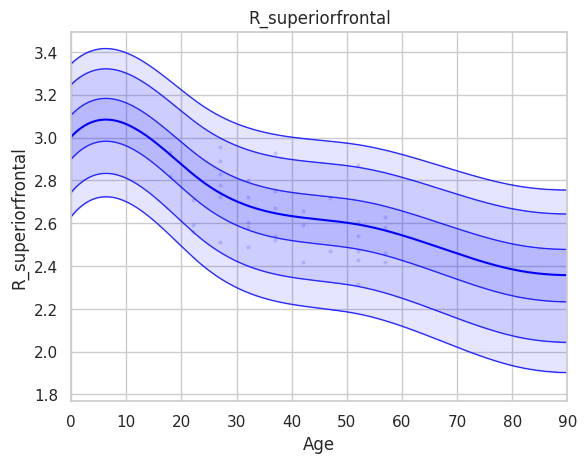

Running IDP 61 R_superiorparietal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12835591]), 'Rho': array([0.26751604]), 'pRho': array([0.00785275]), 'SMSE': array([1.06905936]), 'EXPV': array([-0.01022561])}


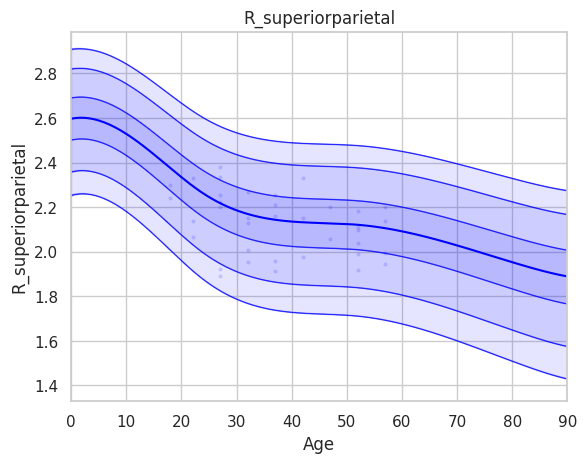

Running IDP 62 R_superiortemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15582246]), 'Rho': array([0.40399823]), 'pRho': array([3.27191958e-05]), 'SMSE': array([0.85718479]), 'EXPV': array([0.14572021])}


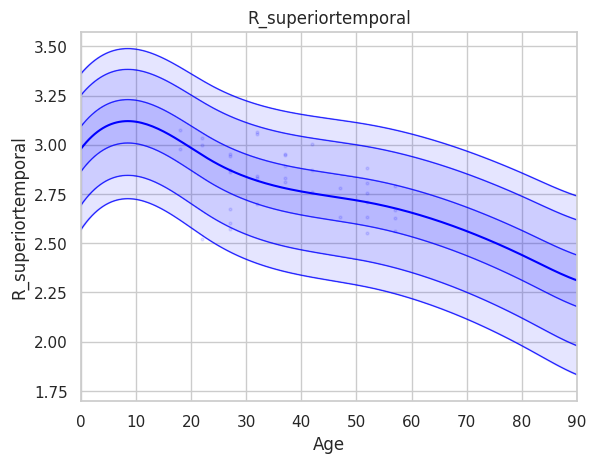

Running IDP 63 R_supramarginal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12919174]), 'Rho': array([0.50731697]), 'pRho': array([5.9341232e-08]), 'SMSE': array([0.89535698]), 'EXPV': array([0.14774546])}


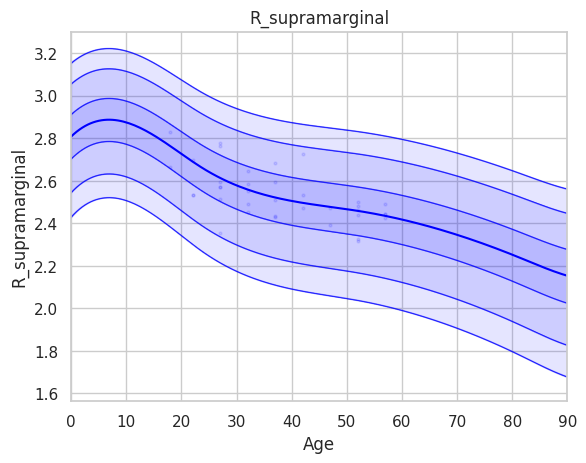

Running IDP 64 R_frontalpole :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.31295994]), 'Rho': array([0.25110539]), 'pRho': array([0.01285526]), 'SMSE': array([0.9463139]), 'EXPV': array([0.06259586])}


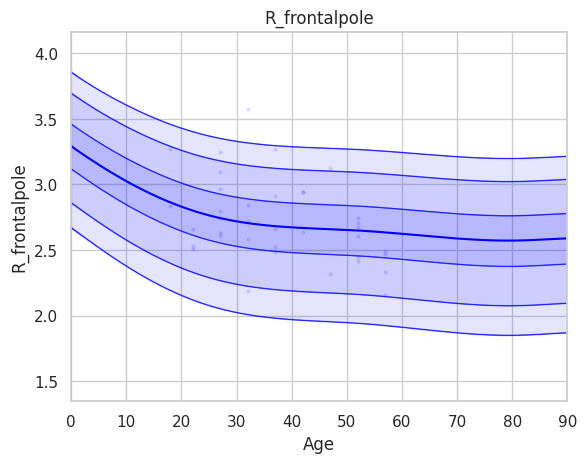

Running IDP 65 R_temporalpole :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.32116484]), 'Rho': array([0.13688397]), 'pRho': array([0.1817053]), 'SMSE': array([1.02740392]), 'EXPV': array([-0.01036151])}


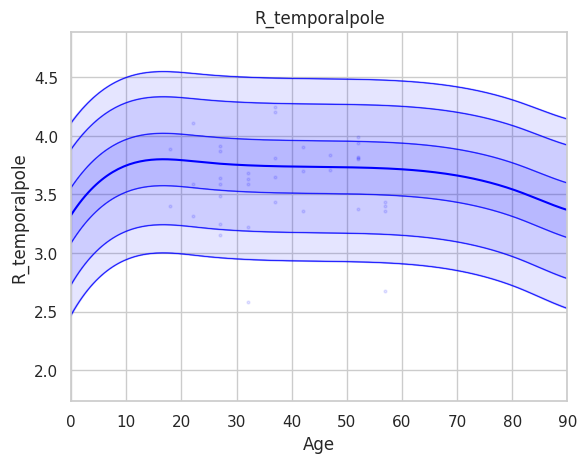

Running IDP 66 R_transversetemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.28226249]), 'Rho': array([0.35228391]), 'pRho': array([0.00035921]), 'SMSE': array([0.91086912]), 'EXPV': array([0.12283519])}


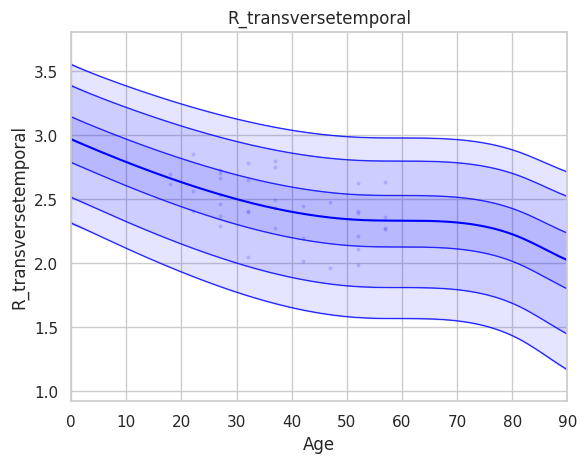

Running IDP 67 R_insula :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14896104]), 'Rho': array([0.49214126]), 'pRho': array([1.74479789e-07]), 'SMSE': array([0.78185905]), 'EXPV': array([0.23941078])}


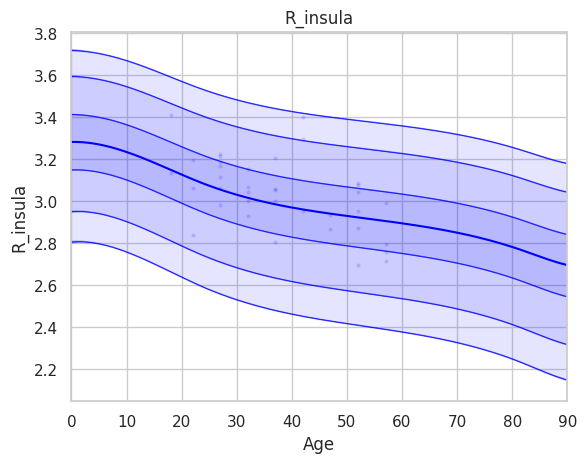

In [28]:
sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids):
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy,
                       alg = 'blr',
                       respfile = None,
                       model_path = os.path.join(idp_dir,'Models'),
                       outputsuffix = '_dummy')

    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle)

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1]

    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))

    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

    # plot the data points
    y_te_rescaled_all = np.zeros_like(y_te)
    for sid, site in enumerate(site_ids_te):
        # plot the true test data points
        if all(elem in site_ids_tr for elem in site_ids_te):
            # all data in the test set are present in the training set

            # first, we select the data points belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, X_te[:,sid+len(cols_cov)+1] !=0))[0]
            if len(idx) == 0:
                print('No data for site', sid, site, 'skipping...')
                continue

            # then directly adjust the data
            idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
            y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
        else:
            # we need to adjust the data based on the adaptation dataset

            # first, select the data point belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, (df_te['site'] == site).to_numpy()))[0]

            # load the adaptation data
            y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
            X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
            idx_a = np.where(np.bitwise_and(X_ad[:,2] == sex, (df_ad['site'] == site).to_numpy()))[0]
            if len(idx) < 2 or len(idx_a) < 2:
                print('Insufficent data for site', sid, site, 'skipping...')
                continue

            # adjust and rescale the data
            y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp,
                                                                   X_ad[idx_a,:],
                                                                   np.squeeze(y_ad[idx_a]),
                                                                   Xs=None,
                                                                   ys=np.squeeze(y_te[idx]))
        # plot the (adjusted) data points
        plt.scatter(X_te[idx,1], y_te_rescaled, s=4, color=clr, alpha = 0.1)

    # plot the median of the dummy data
    plt.plot(xx, med, clr)

    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

    plt.xlabel('Age')
    plt.ylabel(idp)
    plt.title(idp)
    plt.xlim((0,90))
    plt.savefig(os.path.join(idp_dir, 'centiles_' + str(sex)),  bbox_inches='tight')
    plt.show()

os.chdir(out_dir)

In [30]:
# explore an example output folder of a single model (one ROI)
# think about what each of these output files represents.
# Hint: look at the variable names and comments in the code block above
! ls rh_MeanThickness_thickness/

ls: cannot access 'rh_MeanThickness_thickness/': No such file or directory


In [31]:
# check that the number of deviation scores matches the number of subjects in the test set
# there should be one deviation score per subject (one line per subject), so we can
# verify by counting the line numbers in the Z_predict.txt file
! cat rh_MeanThickness_thickness/Z_predict.txt | wc

cat: rh_MeanThickness_thickness/Z_predict.txt: No such file or directory
      0       0       0


The deviation scores are output as a text file in separate folders. We want to summarize the deviation scores across all models estimates so we can organize them into a single file, and merge the deviation scores into the original data file.

In [32]:
! mkdir deviation_scores

mkdir: cannot create directory ‘deviation_scores’: File exists


In [33]:
! for i in *; do if [[ -e ${i}/Z_predict.txt ]]; then cp ${i}/Z_predict.txt deviation_scores/${i}_Z_predict.txt; fi; done

In [34]:
z_dir = '/content/braincharts/models/' + model_name + '/deviation_scores/'

filelist = [name for name in os.listdir(z_dir)]

In [35]:
os.chdir(z_dir)
Z_df = pd.concat([pd.read_csv(item, names=[item[:-4]]) for item in filelist], axis=1)

In [36]:
df_te.reset_index(inplace=True)

In [37]:
Z_df['sub_id'] = df_te['sub_id']

In [38]:
df_te_Z = pd.merge(df_te, Z_df, on='sub_id', how='inner')

In [40]:
df_te_Z.to_csv('PNCtoolkit_deviation_scores.csv', index=False)

In [41]:
from google.colab import files
files.download('PNCtoolkit_deviation_scores.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>